In [1]:
import os
import sys
os.environ["UW_ENABLE_TIMING"] = "1"
import underworld as uw
from underworld import function as fn
from underworld.scaling import units as u
from underworld.scaling import dimensionalise as dm, non_dimensionalise as nd
import glucifer
import numpy as np

In [2]:
#
# Scaling and Units
#
# Dimentional Parameters
airHeight=50.*u.kilometer
modelHeight = 2891 * u.kilometer
earthRadius = 6371 * u.kilometer
modelCartAspect=2
ThetaRAD=np.rad2deg((modelHeight*modelCartAspect)/earthRadius)

# plateHeight = 120. * u.kilometer
refDensity = 3200.0 * u.kilogram / u.meter ** 3
deltaRhoMax = 80.0 * u.kilogram / u.meter ** 3
gravity = 9.8 * u.metre / u.second ** 2
# 1.57e20 * u.pascal * u.second 5.e20 * u.pascal * u.second
refViscosity = 5.0e20 * u.pascal * u.second
bodyForce = deltaRhoMax * gravity

# scaling coefficients
K_eta = refViscosity
KL = modelHeight
K_tau = bodyForce * modelHeight
K_v = K_tau * modelHeight / K_eta
# Kt = KL/K_v
Kt = K_eta / K_tau
KM = K_tau * modelHeight * Kt ** 2

scaling_coefficients = uw.scaling.get_coefficients()

scaling_coefficients["[length]"] = KL.to_base_units()
# scaling_coefficients["[temperature]"] = KT.to_base_units()
scaling_coefficients["[time]"] = Kt.to_base_units()
scaling_coefficients["[mass]"] = KM.to_base_units()

In [40]:
mesh = uw.mesh.FeMesh_Annulus(
        elementRes = (128,256),
        radialLengths = (nd(earthRadius-modelHeight+airHeight),nd(earthRadius)),
        angularExtent=((180-ThetaRAD.magnitude)/2,90+ThetaRAD.magnitude/2)
)
        

velocityField       = mesh.add_variable( nodeDofCount=2 )
pressureField       = mesh.subMesh.add_variable( nodeDofCount=1 )
lower = mesh.specialSets["MinI_VertexSet"]
upper = mesh.specialSets["MaxI_VertexSet"]
swarm = uw.swarm.Swarm(mesh, particleEscape=True)
materialVariable=swarm.add_variable(count=1,dataType="int")
layout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm, particlesPerCell=10)
swarm.populate_using_layout(layout)
advector = uw.systems.SwarmAdvector(velocityField=velocityField, swarm=swarm)


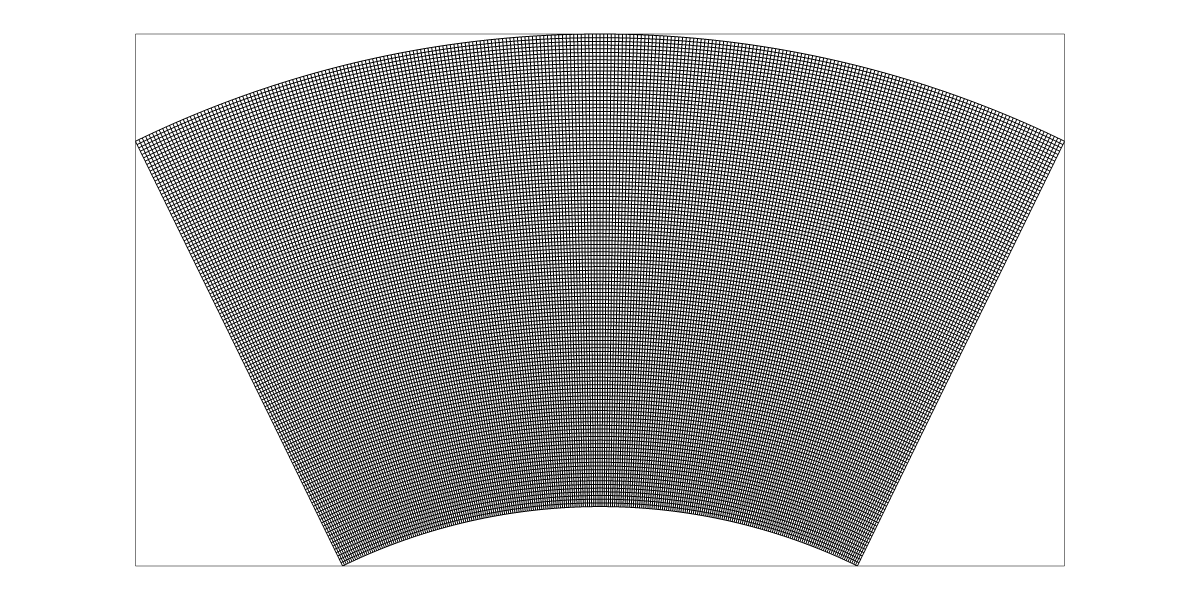

In [41]:
store=None
fig = glucifer.Figure(store=store,figsize=(1200,600))
# fig.append( glucifer.objects.Mesh( mesh ,nodeNumbers=True))
fig.append( glucifer.objects.Mesh( mesh ))
# fig.append( glucifer.objects.Points( swarm,pointsize=4))
fig.show()

In [42]:
radialFn = fn.math.sqrt(fn.math.dot(fn.coord(), fn.coord()))
thetaFn = fn.math.atan2(fn.coord()[1], fn.coord()[0])


In [45]:
# thetaFn.evaluate()

In [50]:

air=mesh.unit_heightFn.evaluate(swarm.data)>nd(modelHeight-airHeight)
lowermantle=mesh.unit_heightFn.evaluate(swarm.data)<nd(modelHeight-airHeight-660.*u.kilometer)
slab=(mesh.unit_heightFn.evaluate(swarm.data)<nd(modelHeight-airHeight)) & \
     (mesh.unit_heightFn.evaluate(swarm.data)>nd(modelHeight-airHeight-100.*u.kilometer)) & \
     (mesh.thetaFn.evaluate(swarm.data)<=np.pi/2)
perturb=(mesh.unit_heightFn.evaluate(swarm.data)<nd(modelHeight-airHeight)) & \
        (mesh.unit_heightFn.evaluate(swarm.data)>nd(modelHeight-airHeight-200.*u.kilometer)) & \
        (mesh.thetaFn.evaluate(swarm.data)<=np.pi/2) & \
        (mesh.thetaFn.evaluate(swarm.data)>=np.pi/2-(100.*u.kilometer/earthRadius).magnitude)
materialVariable.data[:]=1
materialVariable.data[air]=0
materialVariable.data[lowermantle]=2
materialVariable.data[slab|perturb]=3
store=None
fig = glucifer.Figure(store=store,figsize=(1000,650))
# fig.append( glucifer.objects.Mesh( mesh))
fig.append( glucifer.objects.Points( swarm,materialVariable,colours='#00CED1 #F0E68C #FFA500 #2F4F4F',pointsize=2,discrete=True))



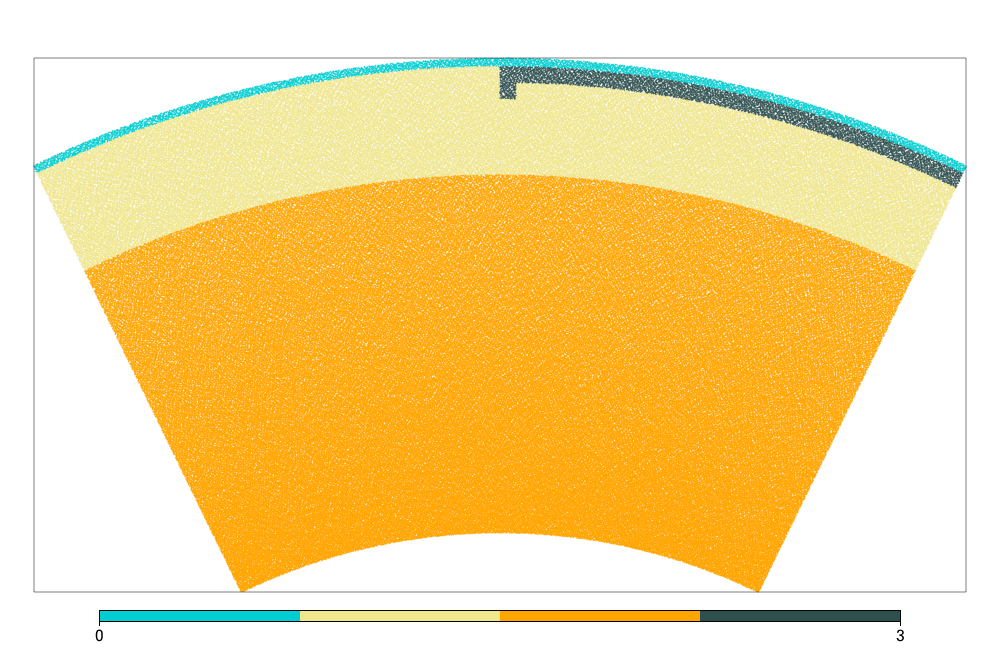

In [51]:
fig.show()


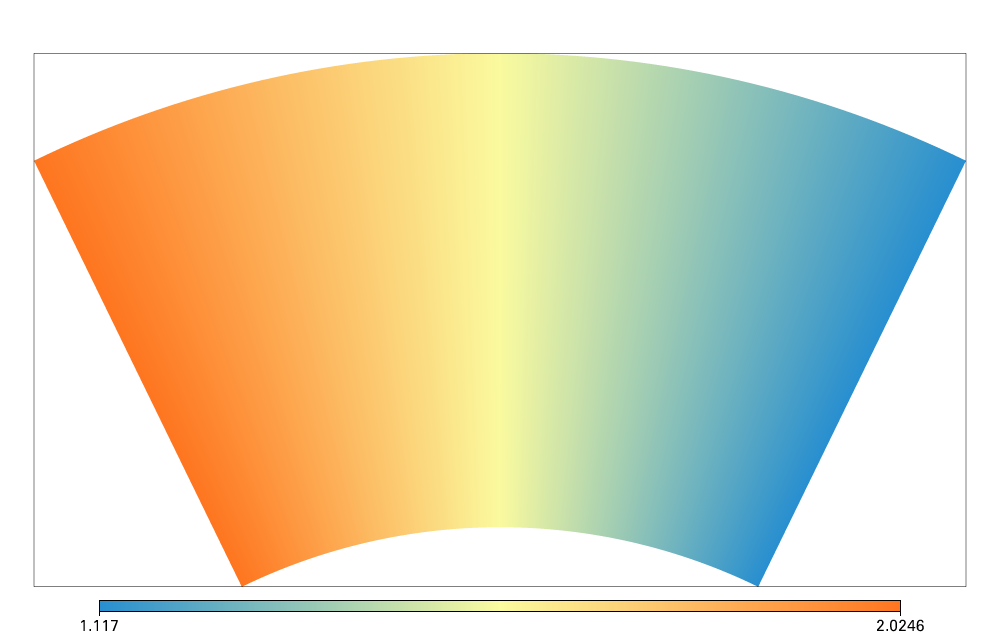

In [13]:
fig = glucifer.Figure(store=store,figsize=(1000,640))
fig.Surface(mesh,thetaFn)
fig.show()

51.998775254221002 <Unit('degree')>